# Introduction to Generative AI

## Imports and constants

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Generation vs Classification task

### Intro and data

In [17]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

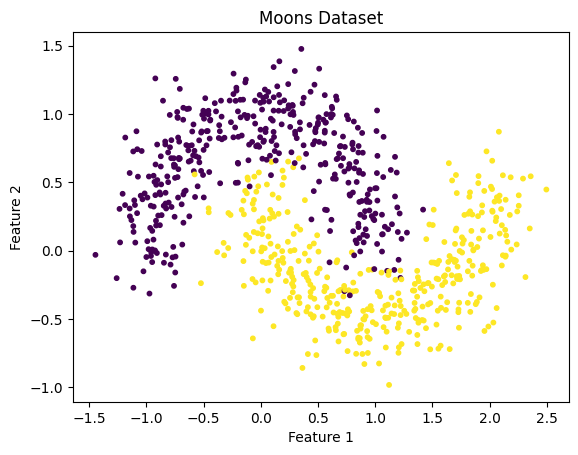

In [18]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset')
plt.show()

**Classification task**: $P(y|x)$

**Generation task**: $P(x|y)$

### Simple classification network

In [35]:
class MoonsClassifier(nn.Module):
    def __init__(self):
        super(MoonsClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [36]:
clf = MoonsClassifier()
clf.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = clf(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = clf(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = ((outputs == y_test_tensor).sum().item()) / y_test_tensor.size(0)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1], Loss: 0.6851, Test Loss: 0.6776, Accuracy: 0.8650
Epoch [2], Loss: 0.6774, Test Loss: 0.6689, Accuracy: 0.8550
Epoch [3], Loss: 0.6687, Test Loss: 0.6596, Accuracy: 0.8150
Epoch [4], Loss: 0.6588, Test Loss: 0.6494, Accuracy: 0.7900
Epoch [5], Loss: 0.6480, Test Loss: 0.6383, Accuracy: 0.8100
Epoch [6], Loss: 0.6363, Test Loss: 0.6282, Accuracy: 0.8150
Epoch [7], Loss: 0.6255, Test Loss: 0.6186, Accuracy: 0.8100
Epoch [8], Loss: 0.6151, Test Loss: 0.6091, Accuracy: 0.8100
Epoch [9], Loss: 0.6048, Test Loss: 0.5989, Accuracy: 0.8050
Epoch [10], Loss: 0.5939, Test Loss: 0.5880, Accuracy: 0.8000
Epoch [11], Loss: 0.5822, Test Loss: 0.5764, Accuracy: 0.8000
Epoch [12], Loss: 0.5698, Test Loss: 0.5641, Accuracy: 0.8050
Epoch [13], Loss: 0.5566, Test Loss: 0.5512, Accuracy: 0.8000
Epoch [14], Loss: 0.5428, Test Loss: 0.5380, Accuracy: 0.7950
Epoch [15], Loss: 0.5286, Test Loss: 0.5250, Accuracy: 0.7900
Epoch [16], Loss: 0.5146, Test Loss: 0.5120, Accuracy: 0.7850
Epoch [17], Loss:

Visualize the decision boundary:

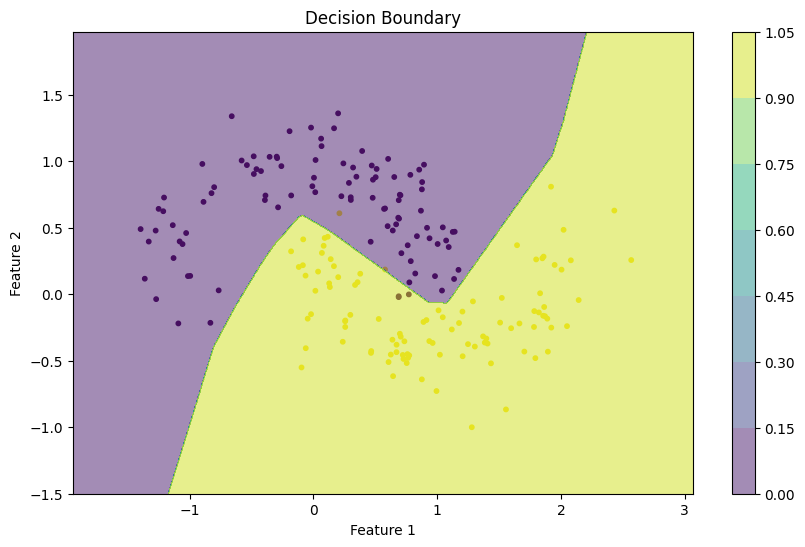

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap='viridis')
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                     np.arange(y_min, y_max, 0.005))
with torch.no_grad():
    Z = clf(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.squeeze().numpy()
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

### Simple generative network

Let's reverse the network:

In [43]:
class MoonsGenerator1(nn.Module):
    def __init__(self):
        super(MoonsGenerator1, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
gen = MoonsGenerator1()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = gen(y_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = gen(y_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.8513, Test Loss: 0.7511
Epoch [2], Loss: 0.7514, Test Loss: 0.6651
Epoch [3], Loss: 0.6683, Test Loss: 0.5963
Epoch [4], Loss: 0.6025, Test Loss: 0.5449
Epoch [5], Loss: 0.5541, Test Loss: 0.5095
Epoch [6], Loss: 0.5218, Test Loss: 0.4873
Epoch [7], Loss: 0.5026, Test Loss: 0.4746
Epoch [8], Loss: 0.4926, Test Loss: 0.4697
Epoch [9], Loss: 0.4900, Test Loss: 0.4682
Epoch [10], Loss: 0.4903, Test Loss: 0.4675
Epoch [11], Loss: 0.4909, Test Loss: 0.4660
Epoch [12], Loss: 0.4900, Test Loss: 0.4630
Epoch [13], Loss: 0.4871, Test Loss: 0.4589
Epoch [14], Loss: 0.4827, Test Loss: 0.4527
Epoch [15], Loss: 0.4759, Test Loss: 0.4449
Epoch [16], Loss: 0.4672, Test Loss: 0.4357
Epoch [17], Loss: 0.4569, Test Loss: 0.4260
Epoch [18], Loss: 0.4461, Test Loss: 0.4163
Epoch [19], Loss: 0.4353, Test Loss: 0.4072
Epoch [20], Loss: 0.4249, Test Loss: 0.3989
Epoch [21], Loss: 0.4154, Test Loss: 0.3919
Epoch [22], Loss: 0.4073, Test Loss: 0.3861
Epoch [23], Loss: 0.4004, Test Loss: 0.38

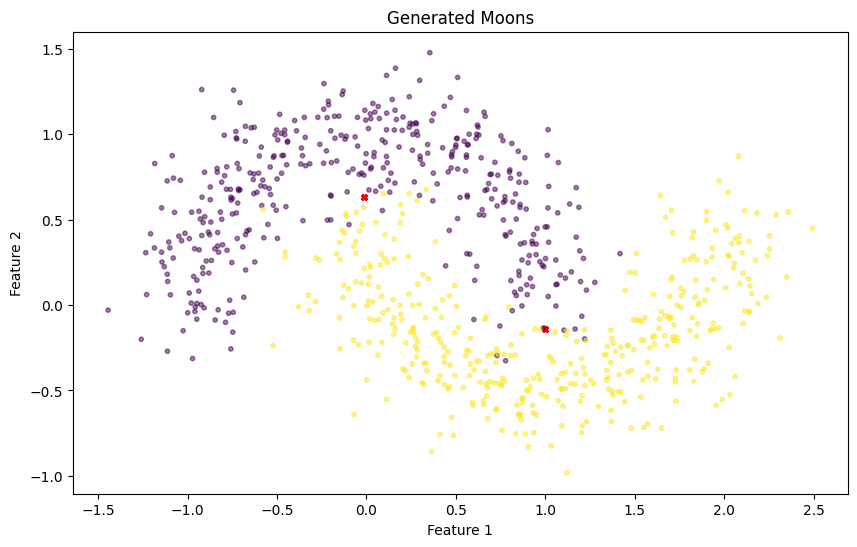

In [49]:
upper_moon_gen = gen(torch.FloatTensor([[1.0]] * 100))
lower_moon_gen = gen(torch.FloatTensor([[0.0]] * 100))
X_gen = torch.cat((upper_moon_gen, lower_moon_gen), dim=0).detach().numpy()
y_gen = np.concatenate((np.ones(100), np.zeros(100)), axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Determenistic $\rightarrow$ single result

In [50]:
class MoonsGenerator2(nn.Module):
    def __init__(self):
        super(MoonsGenerator2, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [51]:
gen = MoonsGenerator2()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_noise = torch.randn(X_train_tensor.size(0), 1)
    y_train_tensor_ = torch.cat((y_train_tensor, train_noise), dim=1)
    outputs = gen(y_train_tensor_)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        test_noise = torch.randn(X_test_tensor.size(0), 1)
        y_test_tensor_ = torch.cat((y_test_tensor, test_noise), dim=1)
        outputs = gen(y_test_tensor_)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.7094, Test Loss: 0.6546
Epoch [2], Loss: 0.6721, Test Loss: 0.6156
Epoch [3], Loss: 0.6362, Test Loss: 0.5861
Epoch [4], Loss: 0.6079, Test Loss: 0.5599
Epoch [5], Loss: 0.5843, Test Loss: 0.5391
Epoch [6], Loss: 0.5533, Test Loss: 0.5152
Epoch [7], Loss: 0.5341, Test Loss: 0.4884
Epoch [8], Loss: 0.5095, Test Loss: 0.4760
Epoch [9], Loss: 0.4935, Test Loss: 0.4523
Epoch [10], Loss: 0.4785, Test Loss: 0.4442
Epoch [11], Loss: 0.4628, Test Loss: 0.4380
Epoch [12], Loss: 0.4527, Test Loss: 0.4216
Epoch [13], Loss: 0.4421, Test Loss: 0.4195
Epoch [14], Loss: 0.4305, Test Loss: 0.4092
Epoch [15], Loss: 0.4208, Test Loss: 0.4004
Epoch [16], Loss: 0.4147, Test Loss: 0.3880
Epoch [17], Loss: 0.4030, Test Loss: 0.3889
Epoch [18], Loss: 0.3927, Test Loss: 0.3795
Epoch [19], Loss: 0.3807, Test Loss: 0.3717
Epoch [20], Loss: 0.3728, Test Loss: 0.3789
Epoch [21], Loss: 0.3637, Test Loss: 0.3607
Epoch [22], Loss: 0.3602, Test Loss: 0.3577
Epoch [23], Loss: 0.3479, Test Loss: 0.36

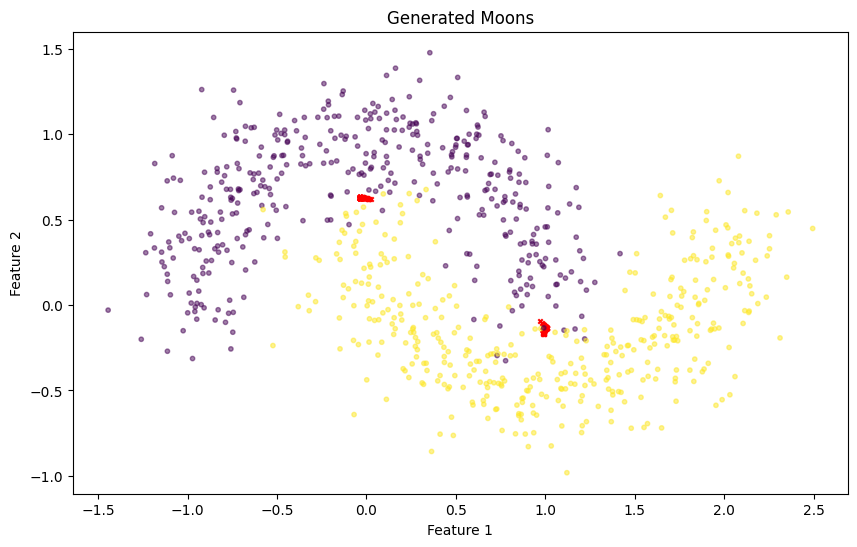

In [55]:
gen_input = torch.cat((torch.cat((torch.FloatTensor([[1.0]] * 100), torch.FloatTensor([[0.0]] * 100)), dim=0), torch.randn(200, 1)), dim=1)
with torch.no_grad():
    X_gen = gen(gen_input)
X_gen = X_gen.detach().numpy()
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Generative tasks in a nutshell

![](./assets/generative1.png)

Problem: complex shape manifold

![](./assets/generative2.png)

Solution: learn mapping to this manifold from the known

![](./assets/generative3.png)

### Common CV generative methods

![](./assets/cv_gen_methods.png)

## Autoencoder

In [99]:
class MoonAutoencoder(nn.Module):
    def __init__(self):
        super(MoonAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        x_reconst = self.decoder(latent)
        return x_reconst
    
    def generate(self, latent):
        x_reconst = self.decoder(latent)
        return x_reconst

In [100]:
model = MoonAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.6641, Test Loss: 0.6178
Epoch [2], Loss: 0.6298, Test Loss: 0.5878
Epoch [3], Loss: 0.6021, Test Loss: 0.5633
Epoch [4], Loss: 0.5799, Test Loss: 0.5437
Epoch [5], Loss: 0.5626, Test Loss: 0.5291
Epoch [6], Loss: 0.5503, Test Loss: 0.5194
Epoch [7], Loss: 0.5429, Test Loss: 0.5142
Epoch [8], Loss: 0.5398, Test Loss: 0.5126
Epoch [9], Loss: 0.5402, Test Loss: 0.5134
Epoch [10], Loss: 0.5427, Test Loss: 0.5153
Epoch [11], Loss: 0.5459, Test Loss: 0.5168
Epoch [12], Loss: 0.5482, Test Loss: 0.5168
Epoch [13], Loss: 0.5487, Test Loss: 0.5152
Epoch [14], Loss: 0.5470, Test Loss: 0.5120
Epoch [15], Loss: 0.5435, Test Loss: 0.5079
Epoch [16], Loss: 0.5388, Test Loss: 0.5033
Epoch [17], Loss: 0.5334, Test Loss: 0.4987
Epoch [18], Loss: 0.5279, Test Loss: 0.4942
Epoch [19], Loss: 0.5224, Test Loss: 0.4896
Epoch [20], Loss: 0.5169, Test Loss: 0.4848
Epoch [21], Loss: 0.5111, Test Loss: 0.4794
Epoch [22], Loss: 0.5046, Test Loss: 0.4728
Epoch [23], Loss: 0.4971, Test Loss: 0.46

In [101]:
gen_input = torch.arange(-5, 5, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = model.generate(gen_input)
X_gen = X_gen.detach().numpy()

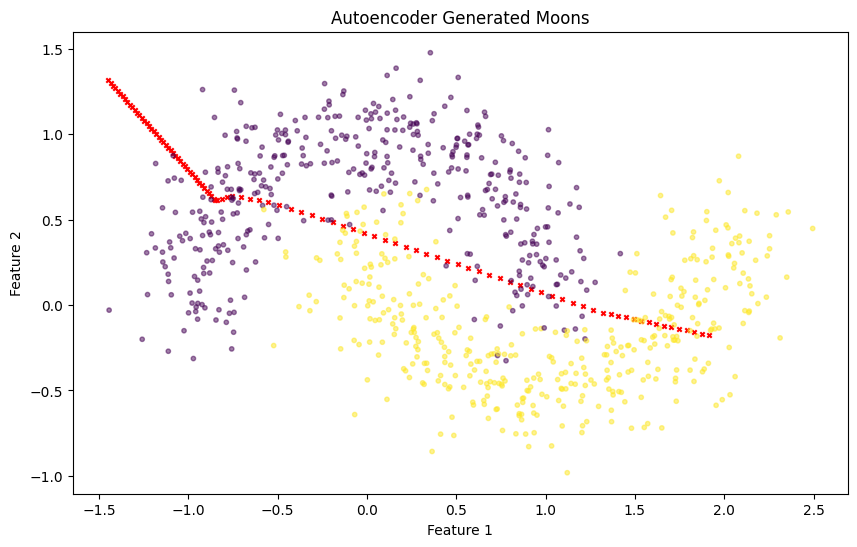

In [102]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [103]:
class MoonConditionalAutoencoder(nn.Module):
    def __init__(self):
        super(MoonConditionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def forward(self, x, y):
        latent = self.encoder(x)
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst
    
    def generate(self, latent, y):
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst

In [104]:
model = MoonConditionalAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor, y_train_tensor.to(torch.long))
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor, y_test_tensor.to(torch.long))
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.7351, Test Loss: 0.7052
Epoch [2], Loss: 0.7109, Test Loss: 0.6833
Epoch [3], Loss: 0.6897, Test Loss: 0.6655
Epoch [4], Loss: 0.6727, Test Loss: 0.6491
Epoch [5], Loss: 0.6570, Test Loss: 0.6338
Epoch [6], Loss: 0.6426, Test Loss: 0.6195
Epoch [7], Loss: 0.6291, Test Loss: 0.6063
Epoch [8], Loss: 0.6169, Test Loss: 0.5939
Epoch [9], Loss: 0.6054, Test Loss: 0.5819
Epoch [10], Loss: 0.5944, Test Loss: 0.5704
Epoch [11], Loss: 0.5838, Test Loss: 0.5592
Epoch [12], Loss: 0.5736, Test Loss: 0.5485
Epoch [13], Loss: 0.5639, Test Loss: 0.5382
Epoch [14], Loss: 0.5546, Test Loss: 0.5282
Epoch [15], Loss: 0.5455, Test Loss: 0.5185
Epoch [16], Loss: 0.5368, Test Loss: 0.5091
Epoch [17], Loss: 0.5283, Test Loss: 0.5000
Epoch [18], Loss: 0.5199, Test Loss: 0.4911
Epoch [19], Loss: 0.5118, Test Loss: 0.4825
Epoch [20], Loss: 0.5038, Test Loss: 0.4741
Epoch [21], Loss: 0.4958, Test Loss: 0.4660
Epoch [22], Loss: 0.4879, Test Loss: 0.4580
Epoch [23], Loss: 0.4800, Test Loss: 0.45

In [106]:
gen_input = torch.arange(-10, 10, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = model.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

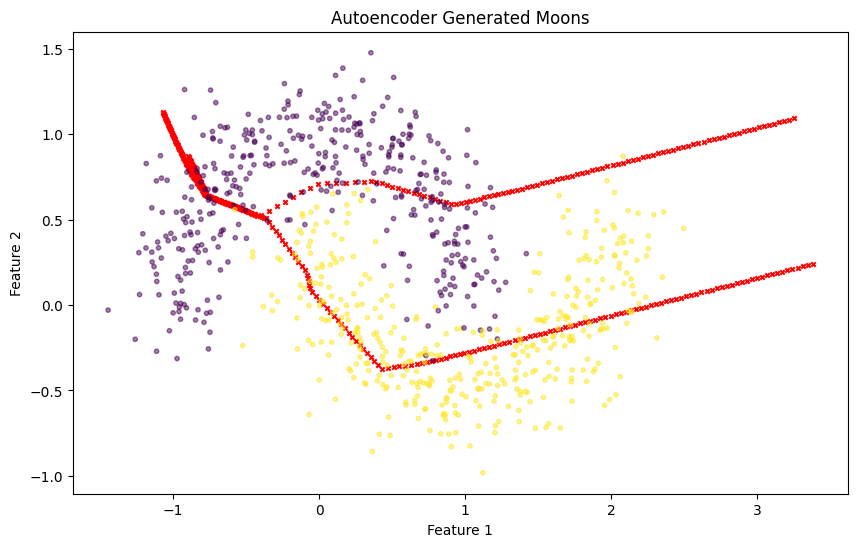

In [107]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Variational autoencoder (VAE)

In [176]:
class MoonVAE(nn.Module):
    def __init__(self):
        super(MoonVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z):
        x_reconst = self.decoder(z)
        return x_reconst

In [228]:
vae = MoonVAE()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor)
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor)
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.6164, Test Reconstruction Loss: 0.5809, Test KL Loss: 27.2916
Epoch [2], Loss: 0.6068, Test Reconstruction Loss: 0.5714, Test KL Loss: 24.0729
Epoch [3], Loss: 0.5970, Test Reconstruction Loss: 0.5647, Test KL Loss: 21.0973
Epoch [4], Loss: 0.5905, Test Reconstruction Loss: 0.5592, Test KL Loss: 18.4925
Epoch [5], Loss: 0.5828, Test Reconstruction Loss: 0.5530, Test KL Loss: 16.2336
Epoch [6], Loss: 0.5763, Test Reconstruction Loss: 0.5465, Test KL Loss: 14.1352
Epoch [7], Loss: 0.5704, Test Reconstruction Loss: 0.5412, Test KL Loss: 12.1179
Epoch [8], Loss: 0.5646, Test Reconstruction Loss: 0.5367, Test KL Loss: 10.1855
Epoch [9], Loss: 0.5606, Test Reconstruction Loss: 0.5316, Test KL Loss: 8.2870
Epoch [10], Loss: 0.5554, Test Reconstruction Loss: 0.5296, Test KL Loss: 6.5077
Epoch [11], Loss: 0.5510, Test Reconstruction Loss: 0.5231, Test KL Loss: 4.9743
Epoch [12], Loss: 0.5485, Test Reconstruction Loss: 0.5201, Test KL Loss: 3.7184
Epoch [13], Loss: 0.5447, Tes

In [229]:
gen_input = torch.arange(-10, 10, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = vae.generate(gen_input)
X_gen = X_gen.detach().numpy()

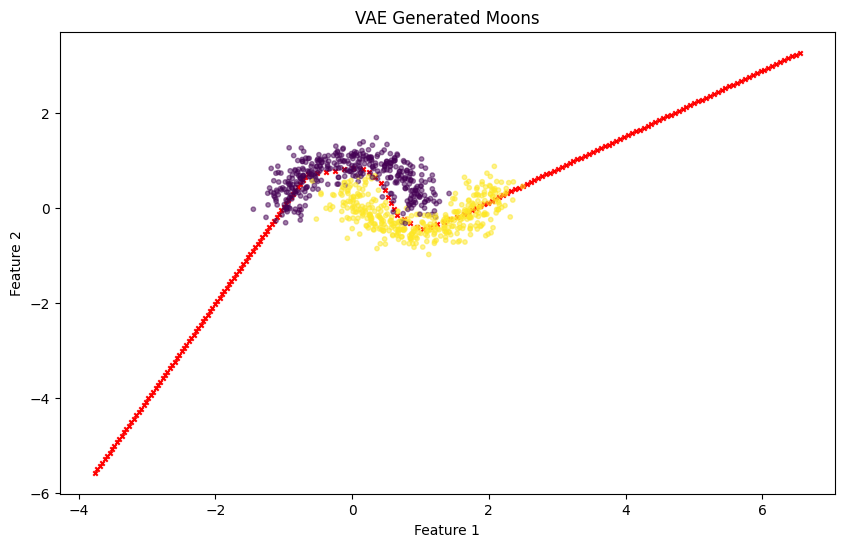

In [230]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [231]:
enc_out = vae.encoder(X_test_tensor)
mu = enc_out[:, 0].unsqueeze(1)
logvar = enc_out[:, 1].unsqueeze(1)

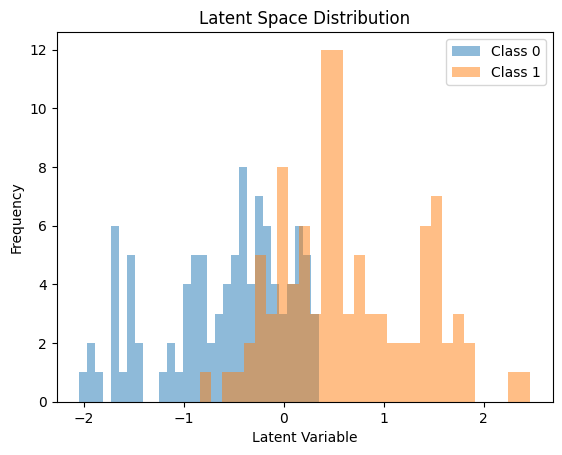

In [232]:
plt.hist(mu[y_test_tensor == 0].detach().numpy(), bins=30, alpha=0.5, label='Class 0')
plt.hist(mu[y_test_tensor == 1].detach().numpy(), bins=30, alpha=0.5, label='Class 1')
plt.title('Latent Space Distribution')
plt.xlabel('Latent Variable')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [159]:
class MoonVAEConditional(nn.Module):
    def __init__(self):
        super(MoonVAEConditional, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)

        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z, y):
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)
        x_reconst = self.decoder(z)
        return x_reconst

In [233]:
vae = MoonVAEConditional()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor, y_train_tensor.to(torch.long))
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor, y_test_tensor.to(torch.long))
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.7718, Test Reconstruction Loss: 0.7364, Test KL Loss: 2.9646
Epoch [2], Loss: 0.7440, Test Reconstruction Loss: 0.7094, Test KL Loss: 2.7678
Epoch [3], Loss: 0.7189, Test Reconstruction Loss: 0.6836, Test KL Loss: 2.6436
Epoch [4], Loss: 0.6984, Test Reconstruction Loss: 0.6646, Test KL Loss: 2.7375
Epoch [5], Loss: 0.6783, Test Reconstruction Loss: 0.6435, Test KL Loss: 3.1076
Epoch [6], Loss: 0.6601, Test Reconstruction Loss: 0.6259, Test KL Loss: 3.7865
Epoch [7], Loss: 0.6421, Test Reconstruction Loss: 0.6127, Test KL Loss: 4.6427
Epoch [8], Loss: 0.6272, Test Reconstruction Loss: 0.5922, Test KL Loss: 5.4577
Epoch [9], Loss: 0.6112, Test Reconstruction Loss: 0.5754, Test KL Loss: 6.0955
Epoch [10], Loss: 0.5992, Test Reconstruction Loss: 0.5636, Test KL Loss: 6.7200
Epoch [11], Loss: 0.5865, Test Reconstruction Loss: 0.5496, Test KL Loss: 7.4544
Epoch [12], Loss: 0.5720, Test Reconstruction Loss: 0.5332, Test KL Loss: 8.5964
Epoch [13], Loss: 0.5640, Test Recons

In [234]:
gen_input = torch.arange(-20, 20, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = vae.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

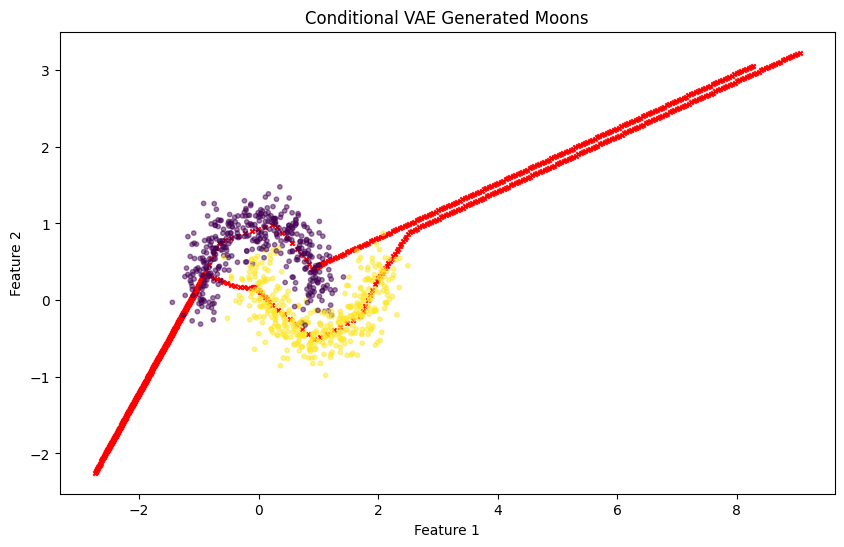

In [235]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Conditional VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Diffusion

![](./assets/diffusion.png)

Diffusion can be formalized as a fixed Markov chain with T steps. Each step depends only on the previous one, allowing us to derive a closed-form formula to obtain the corrupted image at any desired timestep, bypassing the need for iterative computation.

Schedulers:

![](./assets/schedulers.png)



## Evaluating generative CV

## NLP